In [3]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import seaborn as sns

# Exploratory Data Analysis - Pittsburgh Penguins 2015-2016 Playoff Data
## 2015-2016 Stanley Cup Winners
--------
### To begin the EDA process, I use the SQL query below to quickly get the data I'm looking for.
* game type 'P' = Playoff Game
* Penguins team id = 5
### After creating the query, I connected to the NHL_data database and created a pandas df for easier manipulation and analysis.


In [20]:
playoff_20152016_data_query = ('''
SELECT game_plays_trimmed.*, game_plays_players.*, player_info.firstName, player_info.lastName FROM game
JOIN game_plays_trimmed ON game.game_id = game_plays_trimmed.game_id
JOIN game_plays_players ON game_plays_trimmed.play_id = game_plays_players.play_id
JOIN player_info ON game_plays_players.player_id = player_info.player_id
WHERE game.type = 'P'
    AND game.season = 20152016
    AND (
        game.home_team_id = 5
        OR
        game.away_team_id = 5
        );
''')

In [21]:
conn = sqlite3.connect('NHL_data.db')

In [22]:
pens_201516_playoff_df = pd.read_sql_query(playoff_20152016_data_query, conn)

In [23]:
pens_201516_playoff_df.head(10)

,Unnamed: 0,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,...,periodTimeRemaining,dateTime,goals_away,goals_home,play_id,game_id,player_id,playerType,firstName,lastName
0,3165356,2015030141_4,2015030141,5.0,3.0,Faceoff,None,0.0,0.0,1,...,1200.0,2016-04-14 01:10:15,0,0,2015030141_4,2015030141,8471675,Winner,Sidney,Crosby
1,3165356,2015030141_4,2015030141,5.0,3.0,Faceoff,None,0.0,0.0,1,...,1200.0,2016-04-14 01:10:15,0,0,2015030141_4,2015030141,8474613,Loser,Derek,Stepan
2,3165358,2015030141_6,2015030141,3.0,5.0,Faceoff,None,-69.0,22.0,1,...,1193.0,2016-04-14 01:10:52,0,0,2015030141_6,2015030141,8471675,Loser,Sidney,Crosby
3,3165358,2015030141_6,2015030141,3.0,5.0,Faceoff,None,-69.0,22.0,1,...,1193.0,2016-04-14 01:10:52,0,0,2015030141_6,2015030141,8474613,Winner,Derek,Stepan
4,3165359,2015030141_7,2015030141,3.0,5.0,Hit,None,-5.0,-40.0,1,...,1185.0,2016-04-14 01:11:17,0,0,2015030141_7,2015030141,8470630,Hitter,Kevin,Klein
5,3165359,2015030141_7,2015030141,3.0,5.0,Hit,None,-5.0,-40.0,1,...,1185.0,2016-04-14 01:11:17,0,0,2015030141_7,2015030141,8471887,Hittee,Patric,Hornqvist
6,3165360,2015030141_8,2015030141,3.0,5.0,Blocked Shot,None,39.0,7.0,1,...,1175.0,2016-04-14 01:11:17,0,0,2015030141_8,2015030141,8471724,Shooter,Kris,Letang
7,3165360,2015030141_8,2015030141,3.0,5.0,Blocked Shot,None,39.0,7.0,1,...,1175.0,2016-04-14 01:11:17,0,0,2015030141_8,2015030141,8475184,Blocker,Chris,Kreider
8,3165361,2015030141_9,2015030141,5.0,3.0,Hit,None,20.0,40.0,1,...,1173.0,2016-04-14 01:11:25,0,0,2015030141_9,2015030141,8471887,Hitter,Patric,Hornqvist
9,3165361,2015030141_9,2015030141,5.0,3.0,Hit,None,20.0,40.0,1,...,1173.0,2016-04-14 01:11:25,0,0,2015030141_9,2015030141,8475184,Hittee,Chris,Kreider


The query was quick and easy, but seems to have given some repetitive data. To confirm, I checked the columns:

In [24]:
pens_201516_playoff_df.columns

Index(['Unnamed: 0', 'play_id', 'game_id', 'team_id_for', 'team_id_against',
       'event', 'secondaryType', 'x', 'y', 'period', 'periodType',
       'periodTime', 'periodTimeRemaining', 'dateTime', 'goals_away',
       'goals_home', 'play_id', 'game_id', 'player_id', 'playerType',
       'firstName', 'lastName'],
      dtype='object')

As expected, some columns are the same. Also noticeable is how there is both an x, y and a st_x, st_y. Only one set of coordinates is needed. 
Below I drop any duplicated columns, as well as any additional columns that are unnecessary at this time.

In [25]:
pens_201516_playoff_df = pens_201516_playoff_df.iloc[:,~pens_201516_playoff_df.columns.duplicated()]

In [26]:
pens_201516_playoff_df = pens_201516_playoff_df.drop(['dateTime','Unnamed: 0'], axis=1)

I'd like to see what we're looking at for event, secondaryType, and periodType:

In [29]:
pens_201516_playoff_df.head(50)

,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,goals_away,goals_home,player_id,playerType,firstName,lastName
0,2015030141_4,2015030141,5.0,3.0,Faceoff,None,0.0,0.0,1,REGULAR,0,1200.0,0,0,8471675,Winner,Sidney,Crosby
1,2015030141_4,2015030141,5.0,3.0,Faceoff,None,0.0,0.0,1,REGULAR,0,1200.0,0,0,8474613,Loser,Derek,Stepan
2,2015030141_6,2015030141,3.0,5.0,Faceoff,None,-69.0,22.0,1,REGULAR,7,1193.0,0,0,8471675,Loser,Sidney,Crosby
3,2015030141_6,2015030141,3.0,5.0,Faceoff,None,-69.0,22.0,1,REGULAR,7,1193.0,0,0,8474613,Winner,Derek,Stepan
4,2015030141_7,2015030141,3.0,5.0,Hit,None,-5.0,-40.0,1,REGULAR,15,1185.0,0,0,8470630,Hitter,Kevin,Klein
5,2015030141_7,2015030141,3.0,5.0,Hit,None,-5.0,-40.0,1,REGULAR,15,1185.0,0,0,8471887,Hittee,Patric,Hornqvist
6,2015030141_8,2015030141,3.0,5.0,Blocked Shot,None,39.0,7.0,1,REGULAR,25,1175.0,0,0,8471724,Shooter,Kris,Letang
7,2015030141_8,2015030141,3.0,5.0,Blocked Shot,None,39.0,7.0,1,REGULAR,25,1175.0,0,0,8475184,Blocker,Chris,Kreider
8,2015030141_9,2015030141,5.0,3.0,Hit,None,20.0,40.0,1,REGULAR,27,1173.0,0,0,8471887,Hitter,Patric,Hornqvist
9,2015030141_9,2015030141,5.0,3.0,Hit,None,20.0,40.0,1,REGULAR,27,1173.0,0,0,8475184,Hittee,Chris,Kreider


In [30]:
pens_201516_playoff_df.event.unique()

array(['Faceoff', 'Hit', 'Blocked Shot', 'Shot', 'Missed Shot',
       'Giveaway', 'Penalty', 'Takeaway', 'Goal'], dtype=object)

In [31]:
pens_201516_playoff_df.secondaryType.unique()

array([None, 'Snap Shot', 'Wrist Shot', 'Slap Shot', 'Wrap-around',
       'Hooking', 'Tip-In', 'Illegal check to head',
       'Unsportsmanlike conduct', 'Interference', 'Backhand', 'Holding',
       'Tripping', 'Hi stick - double minor', 'Roughing',
       'Interference - Goalkeeper', 'Slashing', 'Cross checking',
       'Fighting', 'Boarding', 'Holding the stick', 'Hi-sticking',
       'Embellishment', 'Too many men on the ice',
       'Delaying Game - Puck over glass', 'Elbowing', 'Misconduct',
       'Deflected'], dtype=object)

In [32]:
pens_201516_playoff_df.periodType.unique()

array(['REGULAR', 'OVERTIME'], dtype=object)

Next, I want to check for null values in the df:

In [33]:
pens_201516_playoff_df.info()
pens_201516_playoff_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13179 entries, 0 to 13178
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   play_id              13179 non-null  object 
 1   game_id              13179 non-null  int64  
 2   team_id_for          13179 non-null  float64
 3   team_id_against      13179 non-null  float64
 4   event                13179 non-null  object 
 5   secondaryType        3586 non-null   object 
 6   x                    13163 non-null  float64
 7   y                    13165 non-null  float64
 8   period               13179 non-null  int64  
 9   periodType           13179 non-null  object 
 10  periodTime           13179 non-null  int64  
 11  periodTimeRemaining  13179 non-null  float64
 12  goals_away           13179 non-null  int64  
 13  goals_home           13179 non-null  int64  
 14  player_id            13179 non-null  int64  
 15  playerType           13179 non-null 

,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,goals_away,goals_home,player_id,playerType,firstName,lastName
0,2015030141_4,2015030141,5.0,3.0,Faceoff,None,0.0,0.0,1,REGULAR,0,1200.0,0,0,8471675,Winner,Sidney,Crosby
1,2015030141_4,2015030141,5.0,3.0,Faceoff,None,0.0,0.0,1,REGULAR,0,1200.0,0,0,8474613,Loser,Derek,Stepan
2,2015030141_6,2015030141,3.0,5.0,Faceoff,None,-69.0,22.0,1,REGULAR,7,1193.0,0,0,8471675,Loser,Sidney,Crosby
3,2015030141_6,2015030141,3.0,5.0,Faceoff,None,-69.0,22.0,1,REGULAR,7,1193.0,0,0,8474613,Winner,Derek,Stepan
4,2015030141_7,2015030141,3.0,5.0,Hit,None,-5.0,-40.0,1,REGULAR,15,1185.0,0,0,8470630,Hitter,Kevin,Klein


Secondary type is the only column that contains null values. What percent are null? Is this column worth keeping?

In [34]:
secondary_type_percent_null = (pens_201516_playoff_df['secondaryType'].isnull().sum())/13179*100
secondary_type_percent_null

72.79004476819182

In [35]:
pens_201516_playoff_df[pens_201516_playoff_df['event']=='Penalty']

,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,goals_away,goals_home,player_id,playerType,firstName,lastName
64,2015030141_45,2015030141,3.0,5.0,Penalty,Hooking,-69.0,-37.0,1,REGULAR,319,881.0,0,0,8473537,PenaltyOn,Viktor,Stalberg
65,2015030141_45,2015030141,3.0,5.0,Penalty,Hooking,-69.0,-37.0,1,REGULAR,319,881.0,0,0,8474602,DrewBy,Justin,Schultz
113,2015030141_75,2015030141,3.0,5.0,Penalty,Illegal check to head,-97.0,28.0,1,REGULAR,647,553.0,0,0,8473537,PenaltyOn,Viktor,Stalberg
114,2015030141_75,2015030141,3.0,5.0,Penalty,Illegal check to head,-97.0,28.0,1,REGULAR,647,553.0,0,0,8474013,DrewBy,Ian,Cole
125,2015030141_84,2015030141,5.0,3.0,Penalty,Unsportsmanlike conduct,NaN,NaN,1,REGULAR,779,421.0,0,0,8468685,DrewBy,Henrik,Lundqvist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13080,2015030416_303,2015030416,5.0,28.0,Penalty,Hooking,-29.0,-33.0,3,REGULAR,326,874.0,2,1,8477839,PenaltyOn,Conor,Sheary
13118,2015030416_329,2015030416,28.0,5.0,Penalty,Slashing,-35.0,11.0,3,REGULAR,662,538.0,2,1,8470613,PenaltyOn,Brent,Burns
13119,2015030416_329,2015030416,28.0,5.0,Penalty,Slashing,-35.0,11.0,3,REGULAR,662,538.0,2,1,8473548,DrewBy,Phil,Kessel
13173,2015030416_369,2015030416,5.0,28.0,Penalty,Hi-sticking,32.0,4.0,3,REGULAR,1190,10.0,3,1,8470611,PenaltyOn,Eric,Fehr


In [36]:
pens_201516_playoff_df[pens_201516_playoff_df['event']=='Shot']

,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,goals_away,goals_home,player_id,playerType,firstName,lastName
12,2015030141_11,2015030141,5.0,3.0,Shot,Snap Shot,45.0,-19.0,1,REGULAR,115,1085.0,0,0,8468685,Goalie,Henrik,Lundqvist
13,2015030141_11,2015030141,5.0,3.0,Shot,Snap Shot,45.0,-19.0,1,REGULAR,115,1085.0,0,0,8473548,Shooter,Phil,Kessel
25,2015030141_20,2015030141,3.0,5.0,Shot,Wrist Shot,-63.0,-6.0,1,REGULAR,165,1035.0,0,0,8473553,Goalie,Jeff,Zatkoff
26,2015030141_20,2015030141,3.0,5.0,Shot,Wrist Shot,-63.0,-6.0,1,REGULAR,165,1035.0,0,0,8476468,Shooter,J.T.,Miller
33,2015030141_24,2015030141,3.0,5.0,Shot,Slap Shot,-47.0,35.0,1,REGULAR,213,987.0,0,0,8470630,Shooter,Kevin,Klein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13132,2015030416_339,2015030416,5.0,28.0,Shot,Slap Shot,-81.0,-5.0,3,REGULAR,858,342.0,2,1,8474889,Goalie,Martin,Jones
13142,2015030416_346,2015030416,5.0,28.0,Shot,Wrist Shot,-76.0,17.0,3,REGULAR,957,243.0,2,1,8474176,Shooter,Carl,Hagelin
13143,2015030416_346,2015030416,5.0,28.0,Shot,Wrist Shot,-76.0,17.0,3,REGULAR,957,243.0,2,1,8474889,Goalie,Martin,Jones
13164,2015030416_363,2015030416,28.0,5.0,Shot,Wrist Shot,57.0,-25.0,3,REGULAR,1154,46.0,3,1,8475820,Shooter,Joonas,Donskoi


After seeing that 73% of secondaryType rows are NULL, I was initially tempted to drop the column entirely.
However, after taking a look at what the unique values are it occured to me that the entries mostly correspond with Shots and Penalties.
Because this information could be very useful, I want to keep the column for now.

### What now? What am I looking for?
I'm curious about the plays and player stats for the 3rd Line. 
For the Playoffs, this was: Carl Hagelin, Nick Bonino, and Phil Kessel (well-known as the 'HBK line')

In [37]:
HBK_line_201516_playoff_df = pens_201516_playoff_df[pens_201516_playoff_df['lastName'].isin(['Hagelin','Bonino','Kessel'])]
HBK_line_201516_playoff_df.head()

,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,goals_away,goals_home,player_id,playerType,firstName,lastName
13,2015030141_11,2015030141,5.0,3.0,Shot,Snap Shot,45.0,-19.0,1,REGULAR,115,1085.0,0,0,8473548,Shooter,Phil,Kessel
14,2015030141_12,2015030141,5.0,3.0,Hit,None,-13.0,37.0,1,REGULAR,121,1079.0,0,0,8473548,Hitter,Phil,Kessel
35,2015030141_26,2015030141,5.0,3.0,Faceoff,None,-69.0,22.0,1,REGULAR,219,981.0,0,0,8474009,Winner,Nick,Bonino
40,2015030141_28,2015030141,5.0,3.0,Blocked Shot,None,-56.0,21.0,1,REGULAR,238,962.0,0,0,8474009,Blocker,Nick,Bonino
63,2015030141_44,2015030141,5.0,3.0,Faceoff,None,-69.0,-22.0,1,REGULAR,316,884.0,0,0,8474009,Winner,Nick,Bonino


In [76]:
def plotHockeyPoints(data, column, column_filter):
    scatter_data = HBK_line_201516_playoff_df.loc[(HBK_line_201516_playoff_df[column]== column_filter)]
    xpoints = np.array(scatter_data['x'])
    ypoints = np.array(scatter_data['y'])
    plt.figure(figsize=(10,8))
    fig = sns.scatterplot(x=xpoints, y=ypoints, data= scatter_data, hue='lastName', size= 'lastName')
    plt.title(f'Location of {column_filter}s 2015 HBK Line')
    im = plt.imread("rink.jpg")
    im = fig.imshow(im, extent=[-105, 105, -45.5, 45.5])
    plt.xlabel=None
    plt.ylabel=None
    fig.set(xticklabels=[])
    fig.set(yticklabels=[])
    fig.grid(False)
    plt.show()
    plt.close()


In [81]:
events = HBK_line_201516_playoff_df.event.unique()
player_types = HBK_line_201516_playoff_df.playerType.unique()

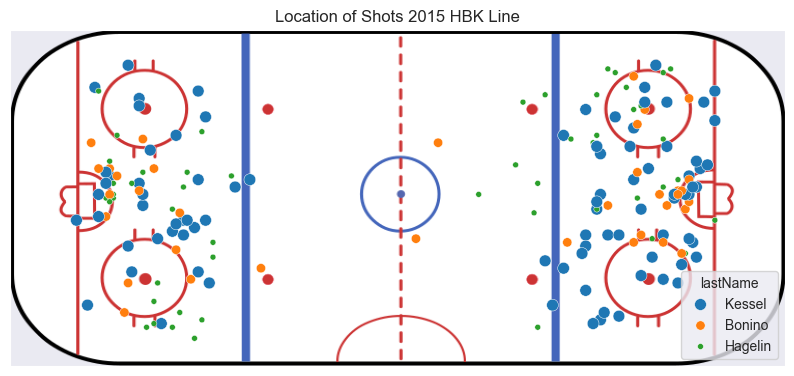

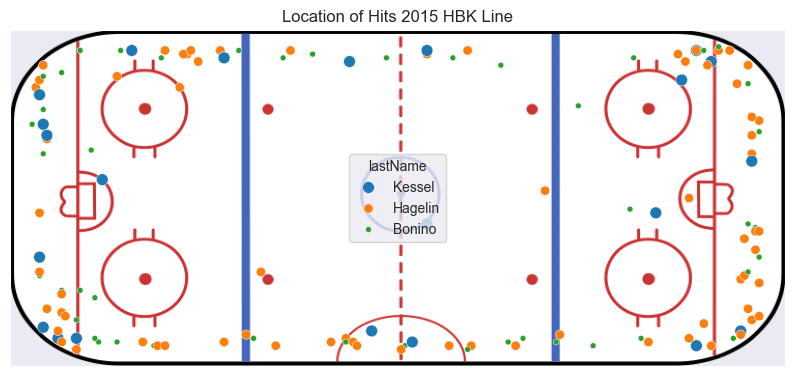

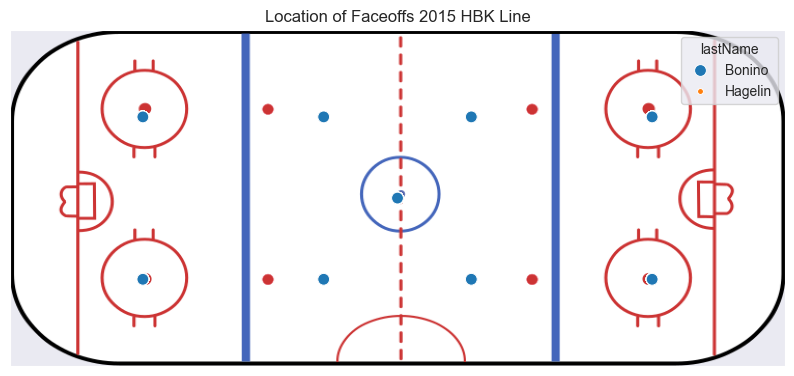

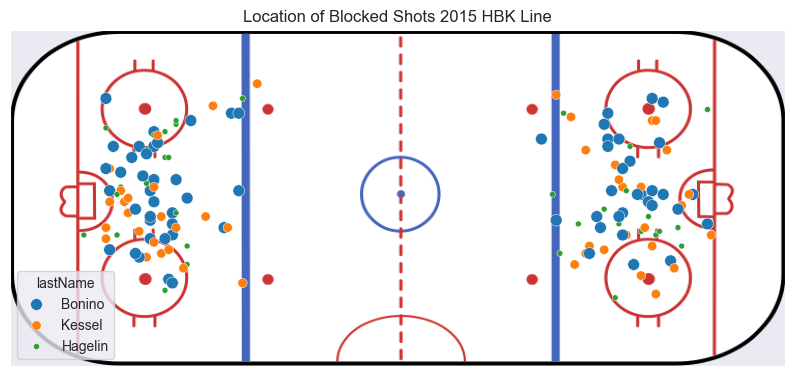

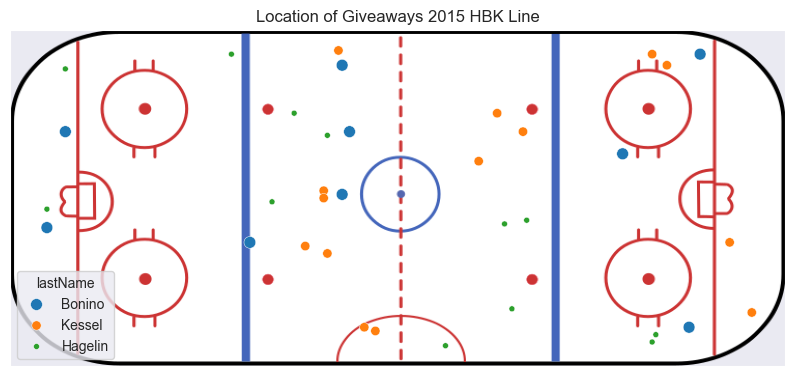

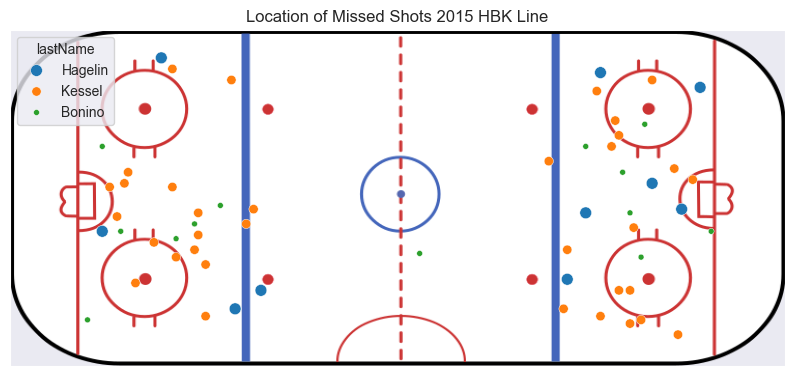

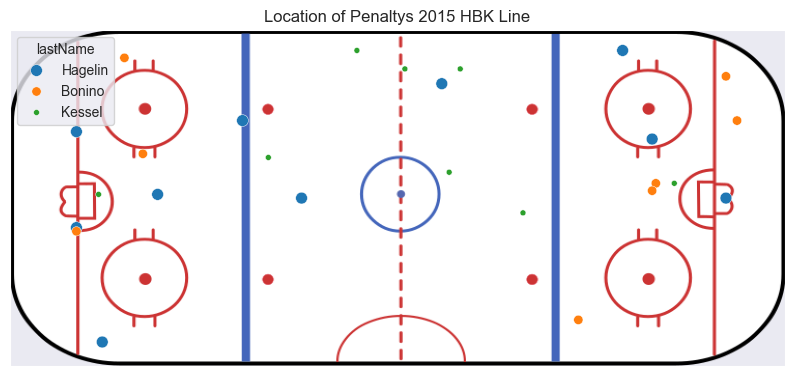

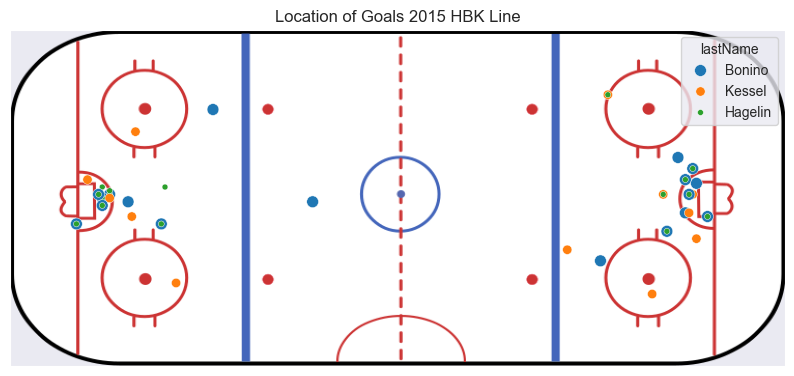

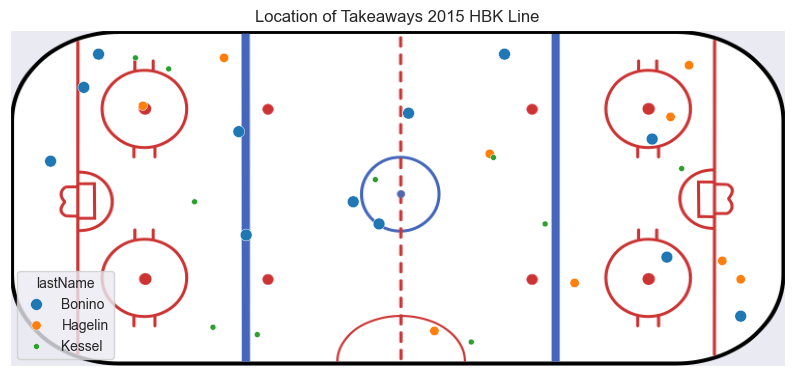

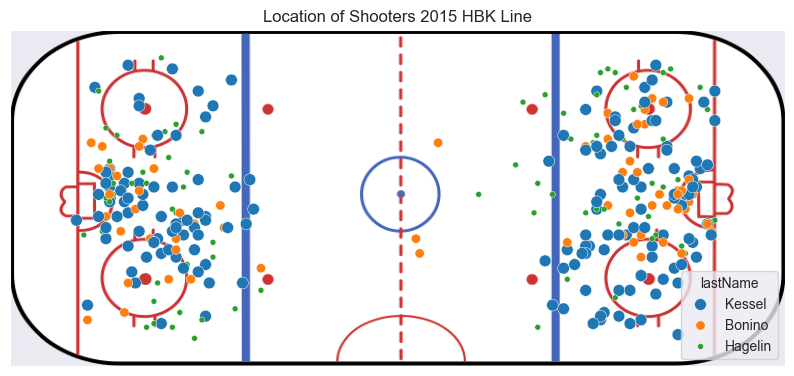

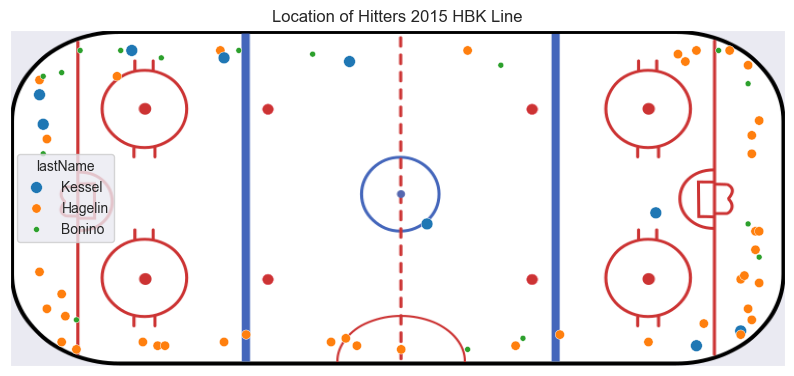

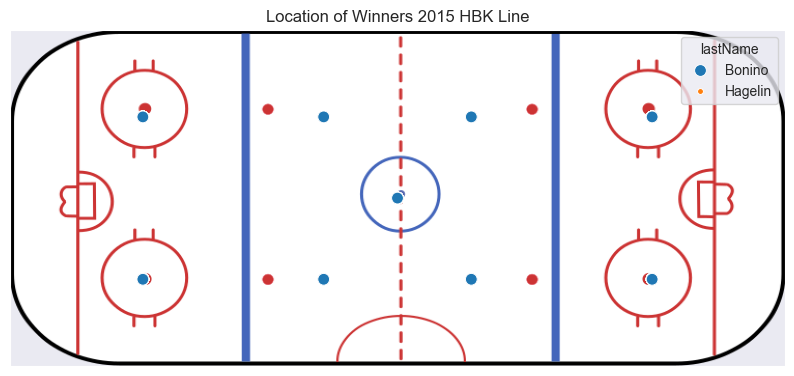

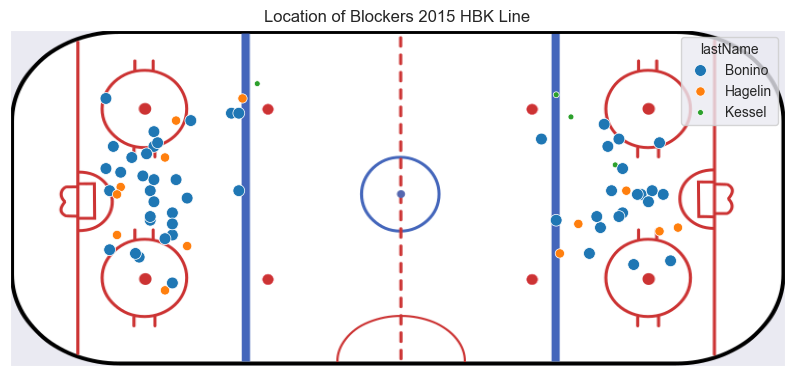

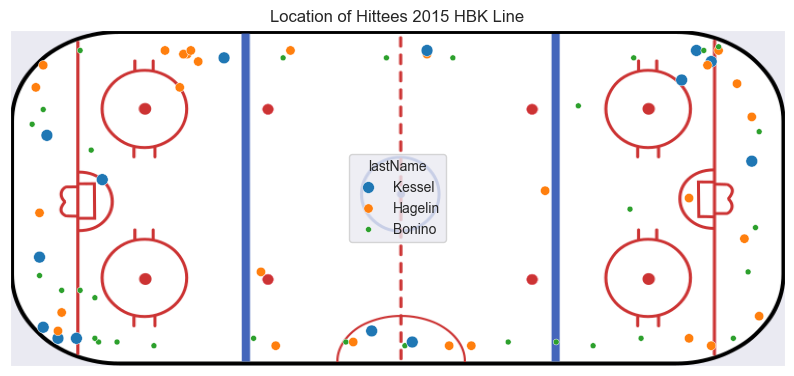

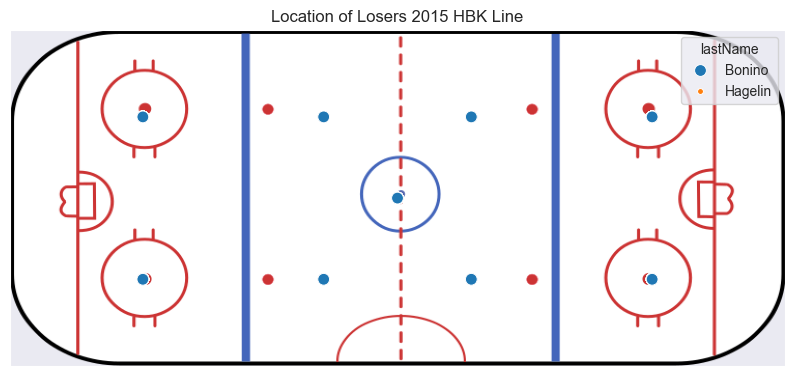

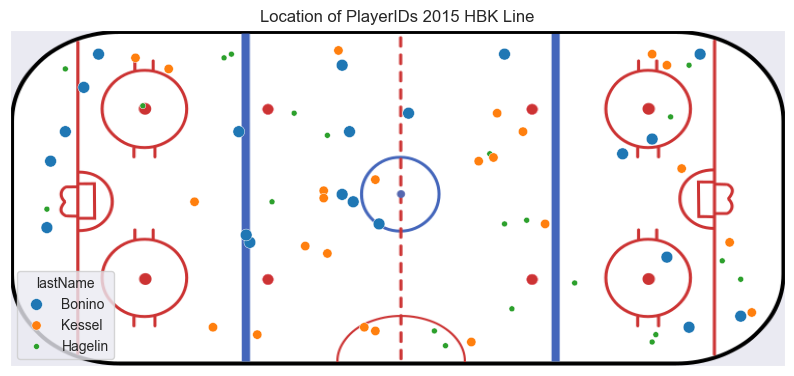

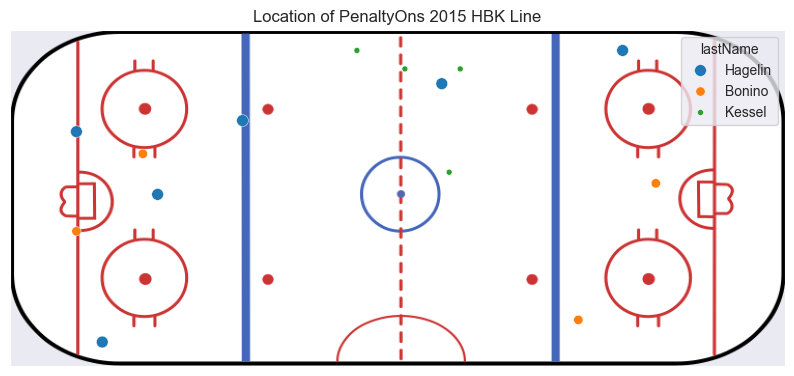

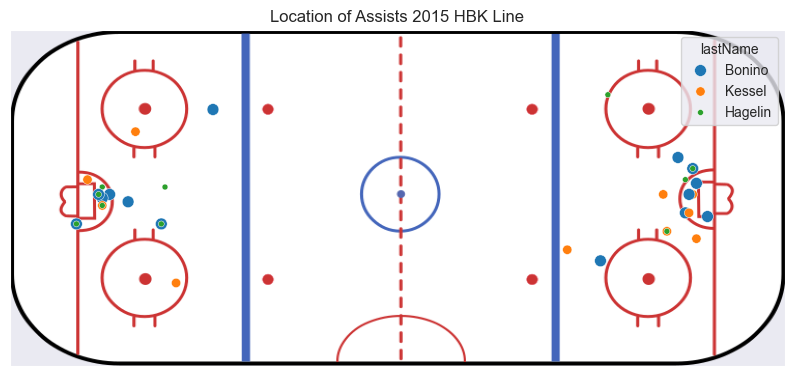

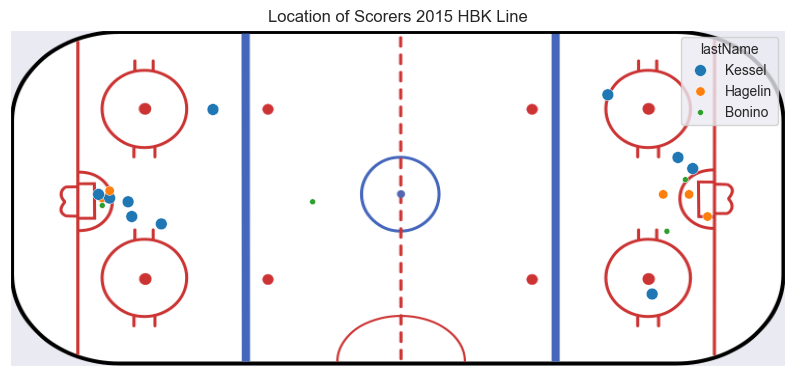

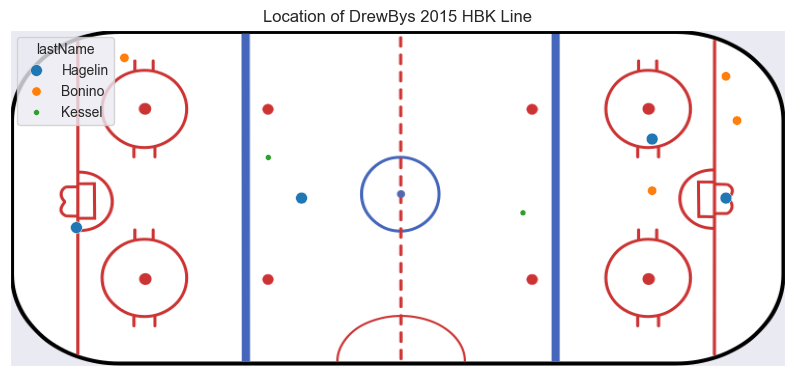

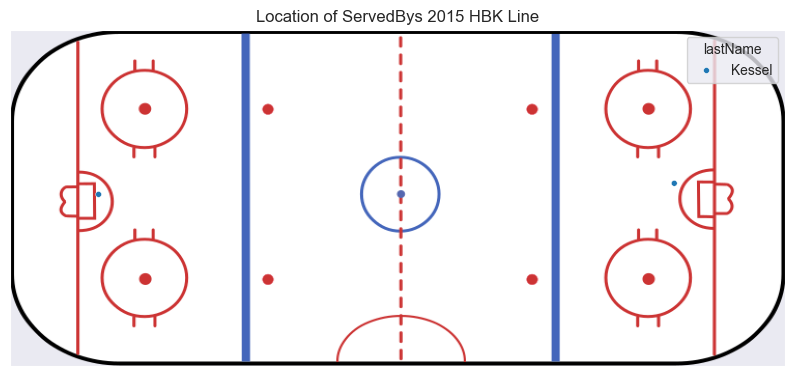

In [82]:
for event in events:
    plotHockeyPoints(HBK_line_201516_playoff_df, 'event', event)
for player_type in player_types:
    plotHockeyPoints(HBK_line_201516_playoff_df, 'playerType', player_type)

In [ ]:
 create_skater_stats_query = ('''
SELECT skater_stats.*
FROM (
    SELECT game_skater_stats.*,
       player_info.firstName,
       player_info.lastName
FROM game_skater_stats
JOIN player_info ON game_skater_stats.player_id = player_info.player_id) skater_stats

LEFT JOIN game ON skater_stats.game_id = game.game_id
WHERE game.season = 20152016
    AND game.type = 'P'
    AND skater_stats.team_id = 5;
''')

In [ ]:
pens_201516_playoff_skater_stats_df = pd.read_sql_query(create_skater_stats_query,conn)

In [ ]:
pens_201516_playoff_skater_stats_df.head()

In [ ]:
pens_201516_playoff_skater_stats_df = pens_201516_playoff_skater_stats_df.drop(['player_id','team_id'], axis=1)

In [ ]:
players_sums_df = pens_201516_playoff_skater_stats_df.groupby('lastName').aggregate({'goals':'sum', 'assists':'sum', 'plusMinus':'sum', 'hits':'sum', 'game_id':'count', 'timeOnIce':'mean'}).reset_index()
players_sums_df = players_sums_df[players_sums_df['game_id']>15]
players_sums_df


In [ ]:
fig = sns.catplot(data= players_sums_df, x='timeOnIce',y='goals',hue='lastName',kind='bar')
fig.set_axis_labels('Average Ice Time (352-1270 seconds)', 'Total Goals')
fig.set(xticklabels=[])
plt.title('Total Goals vs. Time on Ice')


In [ ]:
labels = players_sums_df['lastName']
#colors = ['lightblue', 'beige', 'lightgreen', 'orange', 'cyan', 'magenta','yellow','lightblue', 'beige', 'lightgreen', 'orange', 'cyan', 'magenta','yellow','lightblue', 'beige', 'lightgreen']
explode = [0.3,0,0,0,0,0,0.3,0,0.3,0,0,0,0,0,0,0,0]
sizes = players_sums_df['goals']

plt.figure(0,figsize = (10,10))
plt.pie(sizes, labels=labels, explode = explode, autopct='%1.1f%%')
plt.show()

In [ ]:

fig, ax = plt.subplots()

size = 0.8
vals = np.array([[60., 32.], [37., 40.], [29., 10.]])

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap(np.array([1, 2, 5, 6, 9, 10]))

ax.pie(players_sums_df['goals'], radius=2, colors=outer_colors, labels=players_sums_df['lastName'], autopct='%1.1f%%',
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(players_sums_df['timeOnIce'], radius=2-size, colors=inner_colors, labels=players_sums_df['lastName'], autopct='%1.1f%%',
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Distribution 1 and 2')
plt.show()

In [ ]:
sns.displot(data=pens_201516_playoff_skater_stats_df, x='goals', hue='lastName')
plt.show()

In [ ]:
kessel_stats_df = pens_201516_playoff_skater_stats_df[pens_201516_playoff_skater_stats_df['lastName']=='Kessel']
kessel_stats_df.groupby('game_id').describe()
